# Adult Income Dataset analysis with Skale 

This notebook demonstrates how use Skale to process the data set from Adult Data Set MLR which 
contains income data for about 32000 people. The ultimate goal is to see how well we can predict 
if a person will make more than $50K a year, given data like education, gender and martial status.

To achieve this goal we will:
- Run an ETL operation on raw data to obtain label and features from it
- Build a machine learning model using the refined data (a logistic regression)
- Evaluate the performance of our model using cross-validation technique

We will need the following npm packages.

In [1]:
var sc = require('skale-engine').context();
var co = require('co');
var plot = require('plotter').plot;

We will use the following machine learning capabilities.

In [2]:
var StandardScaler = require('skale-ml').StandardScaler;
var LogisticRegressionWithSGD = require('skale-ml').LogisticRegressionWithSGD;
var BinaryClassificationMetrics = require('skale-ml').BinaryClassificationMetrics;

## Loading the data 

In [3]:
var metadata = {
	workclass: ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
	education: ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
	maritalstatus: ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
	occupation: ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', 'Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
	relationship: ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
	race: ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
	sex: ['Female', 'Male'],
	nativecountry: ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']
}

In [4]:
function featurize(data, metadata) {
	var label = ((data[14] == '>50K') || (data[14] == '>50K.')) ? 1 : -1;
	var features = [
		Number(data[0]),								// 1 age
		metadata.workclass.indexOf(data[1]),			// 2 workclass
		Number(data[2]),								// 3 fnlwgt
		// metadata.education.indexOf(data[3]),			// education (redundant with education-num)
		Number(data[4]),								// 4 education-num
		metadata.maritalstatus.indexOf(data[5]),		// 5 marital-status
		metadata.occupation.indexOf(data[6]),			// 6 occupation	
		metadata.relationship.indexOf(data[7]),			// 7 relationship	
		metadata.race.indexOf(data[8]),					// 8 race
		metadata.sex.indexOf(data[9]),					// 9 sex	
		Number(data[10]),								// 10 capital-gain
		Number(data[11]),								// 11 capital-loss
		Number(data[12]),								// 12 hours-per-week
		metadata.nativecountry.indexOf(data[13])		// 13 native-country
	];
	return [label, features];
}

In [5]:
var training_set = sc.textFile('adult.data')
	.map(line => line.split(',').map(str => str.trim()))		// split csv lines
	.filter(data => data.indexOf('?') == -1)					// remove incomplete data
	.map(featurize, metadata)									// transform string data to number
	.persist();

var test_set = sc.textFile('adult.test')
	.map(line => line.split(',').map(str => str.trim()))		// split csv lines
	.filter(data => data.indexOf('?') == -1)					// remove incomplete data
	.map(featurize, metadata);									// transform string data to number

In [6]:
// Wrap asynchronous code in co to limit callback imbrications (ES7 async/await will fix this !)
co(function* () {
	// Standardize features to zero mean and unit variance
	var scaler = new StandardScaler();

	yield scaler.fit(training_set.map(point => point[1]));			// async !!

	// Use scaler to standardize training and test datasets
	var training_set_std = training_set
		.map((p, args) => [p[0], args.scaler.transform(p[1])], {scaler: scaler})
		.persist();

	var test_set_std = test_set
		.map((p, args) => [p[0], args.scaler.transform(p[1])], {scaler: scaler});

	// Train logistic regression with SGD on standardized training set
	var nIterations = 10;
	var parameters = {regParam: 0.01, stepSize: 1};
	var model = new LogisticRegressionWithSGD(training_set_std, parameters);

	yield model.train(nIterations);									// async !!

	// Evaluate classifier performance on standardized test set
	var predictionAndLabels = test_set_std.map((p, args) => [args.model.predict(p[1]), p[0]], {model: model});
	var metrics = new BinaryClassificationMetrics(predictionAndLabels);

	console.log('\n# Receiver Operating characteristic (ROC)')
	var roc = yield metrics.roc();
	console.log('\nThreshold\tSpecificity(FPR)\tSensitivity(TPR)')
	for (var i in roc)
		console.log(roc[i][0].toFixed(2) + '\t' + roc[i][1][0].toFixed(2) + '\t' + roc[i][1][1].toFixed(2));

	// Ploting ROC curve as roc.png
	var xy = {};
	for (var i in roc)
		xy[roc[i][1][0].toFixed(2)] = roc[i][1][1].toFixed(2)
	xy['0.00'] = '0.00';
	var data = {};
	data['regParam: ' + parameters.regParam + ', stepSize: ' + parameters.stepSize] = xy;
	data['Random'] = {0 :0, 1 : 1};
	plot({
		title: 'Logistic Regression ROC Curve', 
		data: data, 
		filename: 'roc.png'
		//finish: function() {sc.end();}
	});
});

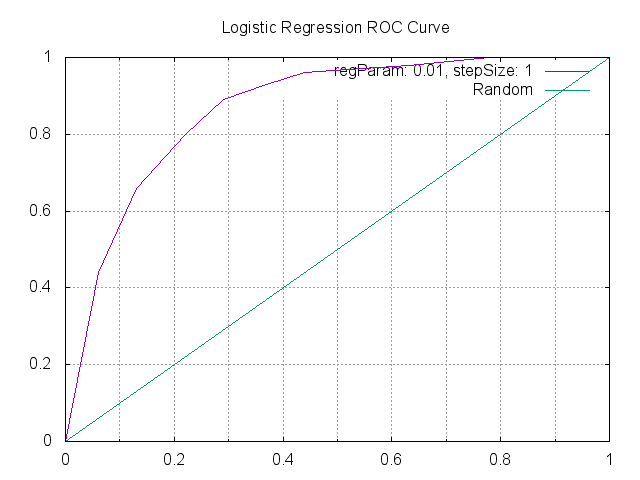


# Receiver Operating characteristic (ROC)

Threshold	Specificity(FPR)	Sensitivity(TPR)
0.00	1.00	1.00
0.10	0.78	1.00
0.20	0.63	0.98
0.30	0.52	0.97
0.40	0.44	0.96
0.50	0.37	0.93
0.60	0.29	0.89
0.70	0.22	0.80
0.80	0.13	0.66
0.90	0.06	0.44
stdout: 
stderr: 


In [7]:
$$png$$ = require("fs").readFileSync("roc.png").toString("base64");